**Problem 4** Early Stopping and variable learning rate.

The main changes are at the SGD function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import gzip

In [2]:
IMG_LEN = 28
IMG_SIZE = IMG_LEN**2

In [3]:
class QuadraticLoss(object):
    @staticmethod
    def loss(a, y):
        return 0.5*np.dot(a-y, a-y)
    @staticmethod
    def loss_derivative(a, y):
        return a-y

In [4]:
class CrossEntropyLoss(object):
    @staticmethod
    def loss(a, y):
        return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))
    @staticmethod
    def loss_derivative(a, y):
        return (a-y)/(a*(1.0-a))

In [5]:
epsilon=10**(-2)

In [6]:
class Network(object):
    def __init__(self, n, *, loss=QuadraticLoss, init='standard'):
        # Initialize the weights randomly
        if init == 'standard':
            self.W = np.random.randn(n, IMG_SIZE)
            self.V = np.random.randn(10, n)
        elif init == 'normalized':
            self.W = np.random.randn(n, IMG_SIZE) / np.sqrt(IMG_SIZE)
            self.V = np.random.randn(10, n) / np.sqrt(n)

        self.b = np.random.randn(n)
        self.bprime = np.random.randn(10)
        self.loss = loss

    def feedforward(self, x):
        # Return the output of a feedforward pass
        a = sigmoid(np.dot(self.W, x)+self.b)
        return sigmoid(np.dot(self.V, a)+self.bprime)

    def evaluate(self, data, *, lmbda=0):
        """ Return (cost, accuracy) on the data"""
        correct_samples = 0
        total_cost = 0
        n_samples = len(data)

        for x, ylabel in data:
            y = self.feedforward(x)
            prediction = np.argmax(y)
            if prediction == ylabel:
                correct_samples += 1

            total_cost += self.loss.loss(y, Network.vec_output[ylabel])

        average_cost = total_cost / n_samples
        average_cost += 0.5*lmbda*(
            np.linalg.norm(self.W)**2 + np.linalg.norm(self.V)**2)

        return average_cost, correct_samples / n_samples


    def update_mini_batch(self, mini_batch, eta, lmbda):
        # Run backprop and update weights on the minibatch
        k = len(mini_batch)
        delta_W = np.zeros(self.W.shape)
        delta_b = np.zeros(self.b.shape)
        delta_V = np.zeros(self.V.shape)
        delta_bprime = np.zeros(self.bprime.shape)

        for x, y in mini_batch:
            nabla_W, nabla_b, nabla_V, \
                nabla_bprime = self.backprop(x, y)
            delta_W += nabla_W
            delta_b += nabla_b
            delta_V += nabla_V
            delta_bprime += nabla_bprime

        self.W -= eta*(lmbda*self.W + 1/k * delta_W)
        self.b -= eta/k * delta_b
        self.V -= eta*(lmbda*self.V + 1/k * delta_V)
        self.bprime -= eta/k * delta_bprime

    def SGD(self, training_data, *, mini_batch_size,
            eta, lmbda=0, test_data=[]):
        # Run SGD with those parameters
        # Return a list of results for every epoch
        # For each epoch, append pair (self.evaluate(training_data),
        #        self.evaluate(test_data))
        res = []
        acc=[0,0,0,0,self.evaluate(test_data)[1]]
        #acc_0=0
        #acc_1=self.evaluate(test_data)[1]
        epochs=0
        for r in range(4):

          while  np.abs(acc[0]-acc[1])>epsilon or np.abs(acc[1]-acc[2])>epsilon or np.abs(acc[2]-acc[3])>epsilon or np.abs(acc[3]-acc[4])>epsilon:

            np.random.shuffle(training_data)
            for j in range(0, len(training_data), mini_batch_size):
                mini_batch = training_data[j:j+mini_batch_size]
                self.update_mini_batch(mini_batch, eta, lmbda)

            res.append((self.evaluate(training_data),
                        self.evaluate(test_data)))

            print('Epoch '+str(epochs)+' finished')
            if epochs>4:
              acc[0]=res[epochs-4][1][1]
              acc[1]=res[epochs-3][1][1]
              acc[2]=res[epochs-2][1][1]
              acc[3]=res[epochs-1][1][1]
              acc[4]=self.evaluate(test_data)[1]
            #acc_0=acc_1
            #acc_1=self.evaluate(test_data)[1]
            epochs+=1
        eta/=3
        return res

    def backprop(self, x, ylabel):
        # feedforward
        z1 = np.dot(self.W, x)+self.b
        a1 = sigmoid(z1)
        z2 = np.dot(self.V, a1)+self.bprime
        a2 = sigmoid(z2)

        # backward
        delta_2 = self.loss.loss_derivative(a2, Network.vec_output[ylabel]) * sigmoid_prime(z2)
        nabla_bprime = delta_2
        nabla_V = np.outer(delta_2, a1)

        delta_1 = np.dot(self.V.transpose(), delta_2) * sigmoid_prime(z1)
        nabla_b = delta_1
        nabla_W = np.outer(delta_1, x)

        return nabla_W, nabla_b, nabla_V, nabla_bprime

    vec_output = []
    for ylabel in range(10):
        V = np.zeros(10)
        V[ylabel] = 1
        vec_output.append(V)

In [7]:
def sigmoid(z):
    return 1 / (1.0+np.exp(-z))
def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))

In [8]:
def load_data():
    # Note you have to update the path below
    f = gzip.open('mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
    f.close()
    return training_data, validation_data, test_data

In [9]:
TRAIN, VALIDATION, TEST = load_data()

In [10]:
def zip_data(D):
    return list(zip(D[0], D[1]))

In [11]:
train_data = zip_data(TRAIN)
validation_data = zip_data(VALIDATION)
test_data = zip_data(TEST)

In [12]:
def plot_results(res):
    X = list(range(len(res)))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    train_acc = [x[0][1] for x in res]
    test_acc = [x[1][1] for x in res]
    ax1.plot(X, train_acc, label='train')
    ax1.plot(X, test_acc, label='test')
    ax1.legend()

    train_cost = [x[0][0] for x in res]
    test_cost = [x[1][0] for x in res]
    ax2.plot(X, train_cost, label='train')
    ax2.plot(X, test_cost, label='test')
    ax2.legend()

    print(np.max([x[1][1] for x in res]))

### Original training

In [13]:
NET = Network(30)
results = NET.SGD(train_data,
                  mini_batch_size=10,
                  eta=3.0,
                  test_data=test_data)

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished
Epoch 5 finished


0.9392


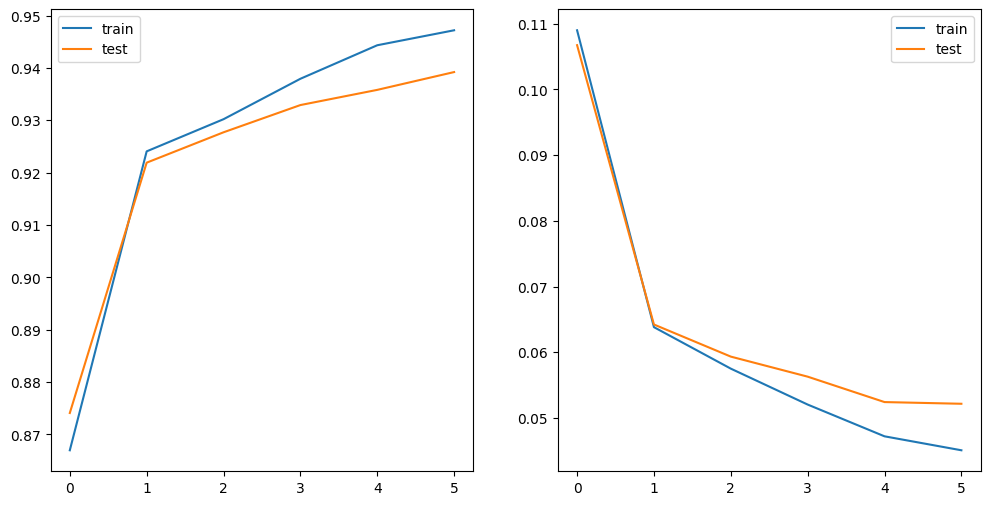

In [14]:
plot_results(results)

### Cross-entropy loss, $\eta=3.0$

In [16]:
NET = Network(30, loss=CrossEntropyLoss)

In [17]:
results = NET.SGD(train_data,
                  mini_batch_size=10,
                  eta=3.0,
                  test_data=test_data)

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished
Epoch 5 finished
Epoch 6 finished


0.9322


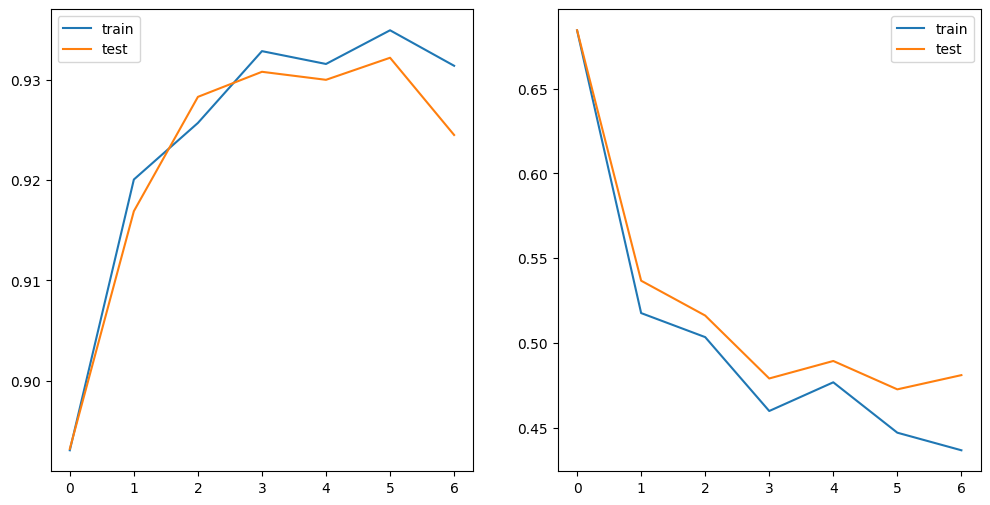

In [18]:
plot_results(results)

### Cross-entropy loss, $\eta=0.5$

In [19]:
NET2 = Network(30, loss=CrossEntropyLoss)
results2 = NET2.SGD(train_data,
                    mini_batch_size=10,
                    eta=0.5,
                    test_data=test_data)

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished
Epoch 5 finished


0.9403


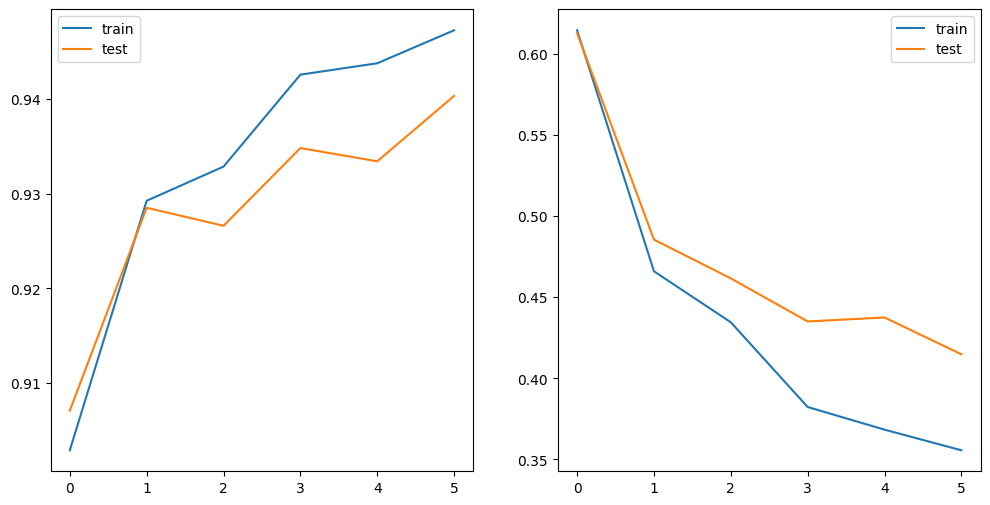

In [20]:
plot_results(results2)

### Added L2 regularization, $\lambda=10^{-4}$

In [21]:
NET3 = Network(30, loss=CrossEntropyLoss)
results3 = NET3.SGD(train_data,
                    mini_batch_size=10,
                    eta=0.5,
                    lmbda=10**(-4),
                    test_data=test_data)

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished
Epoch 5 finished


0.9514


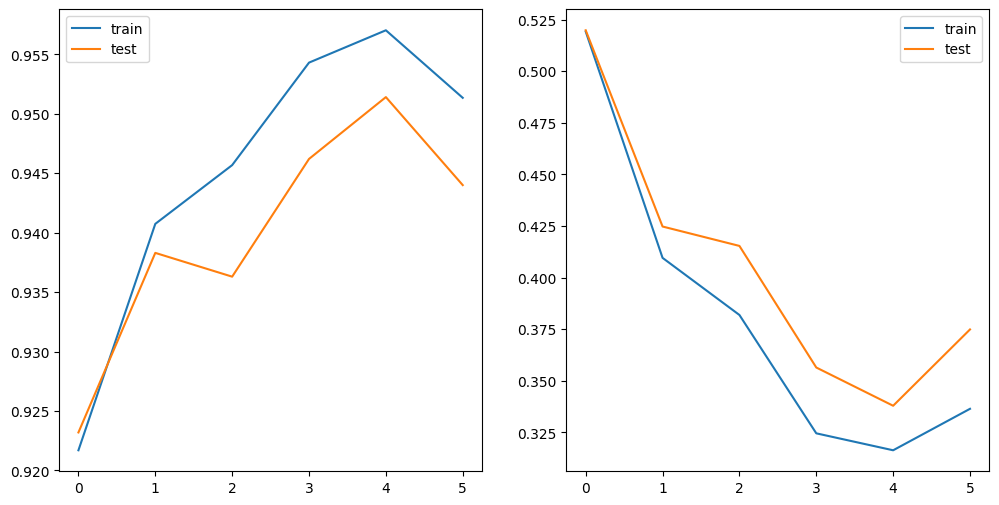

In [22]:
plot_results(results3)

### Added normalized initialization

In [23]:
NET4 = Network(30, loss=CrossEntropyLoss, init='normalized')
results4 = NET4.SGD(train_data,
                    mini_batch_size=10,
                    eta=0.5,
                    lmbda=10**(-4),
                    test_data=test_data)

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished
Epoch 5 finished


0.9542


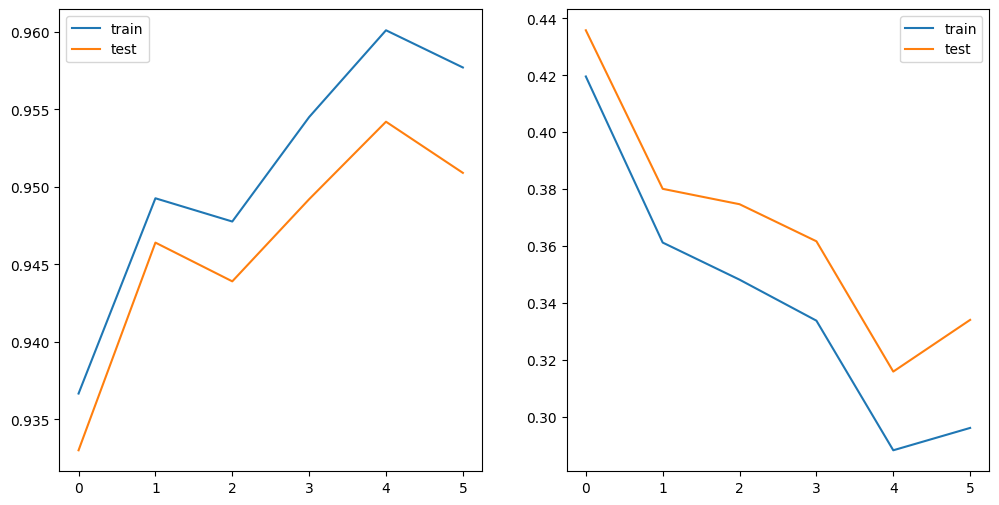

In [24]:
plot_results(results4)

### Added data augmentation

In [25]:
def plot_digit(img):
    img = np.reshape(img, (IMG_LEN, IMG_LEN))
    plt.imshow(1-img, cmap='gray')

In [26]:
def shifted_image(img, shift_r, shift_c):
    img = np.reshape(img, (IMG_LEN, IMG_LEN))
    res = np.zeros_like(img)
    for row in range(IMG_LEN):
        new_row = row + shift_r
        if new_row >= 0 and new_row < IMG_LEN:
            for col in range(IMG_LEN):
                new_col = col + shift_c
                if new_col >= 0 and new_col < IMG_LEN:
                    res[new_row, new_col] = img[row, col]
    return np.reshape(res, (IMG_SIZE,))

(None, 0)

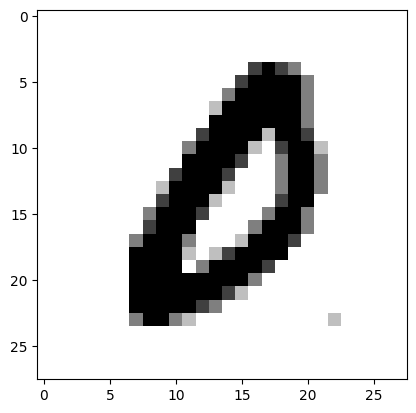

In [27]:
plot_digit(train_data[30][0]), train_data[30][1]

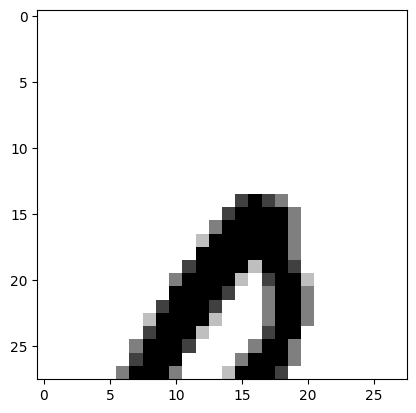

In [28]:
plot_digit(shifted_image(train_data[30][0], 10, -1))

In [29]:
expanded_train_data = []
for x, ylabel in train_data:
    expanded_train_data.append((x, ylabel))
    for r_shift, c_shift in [(+1, 0), (-1, 0), (0, +1), (0, -1)]:
        expanded_train_data.append((
            shifted_image(x, r_shift, c_shift),
            ylabel
        ))

In [30]:
len(expanded_train_data)

250000

### Network run on expanded data set

In [32]:
NET5 = Network(30, loss=CrossEntropyLoss, init='normalized')
results5 = NET5.SGD(expanded_train_data,
                    mini_batch_size=10,
                    eta=0.5,
                    lmbda=10**(-4),
                    test_data=test_data)

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished
Epoch 5 finished


0.9646


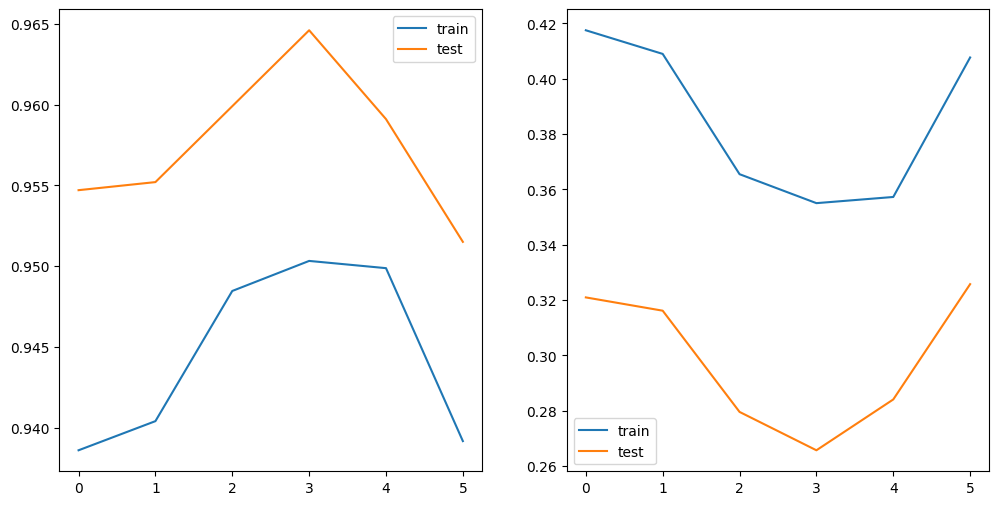

In [33]:
plot_results(results5)

### Finally, let's make it 100 neurons

In [34]:
NET5 = Network(100, loss=CrossEntropyLoss, init='normalized')
results5 = NET5.SGD(expanded_train_data,
                    mini_batch_size=10,
                    eta=0.5,
                    lmbda=10**(-4),
                    test_data=test_data)

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished
Epoch 5 finished


0.9796


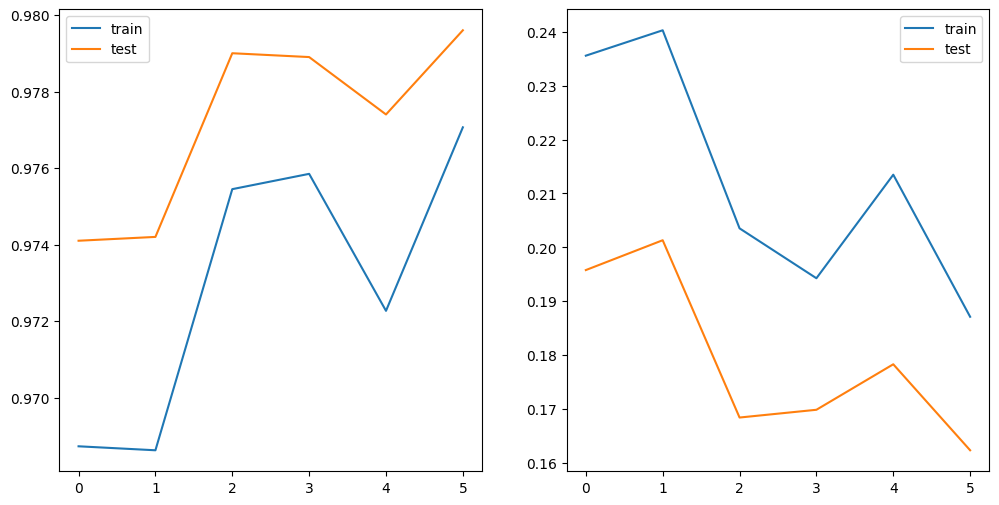

In [35]:
plot_results(results5)

**General comment:**

In general , the accuracy with this method is not too far from what we got with other but what we gained here is time . In most of cases the number of epochs is few.


**Problem 5 : Mnist Fashion data**.




**Package loading**

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt


**Load the data**

In [2]:
tf.keras.datasets.fashion_mnist?

In [4]:
 data=tf.keras.datasets.fashion_mnist.load_data()


**Explore the data**

In [5]:
type(data),len(data)

(tuple, 2)

In [6]:
type(data[0]),type(data[1])

(tuple, tuple)

In [7]:
type(data[0]),len(data[0]),type(data[1]),len(data[1])

(tuple, 2, tuple, 2)

With informations on the shape and reading the documentation of the package (https://keras.io/api/datasets/fashion_mnist/) , we can split the data as follow:

In [8]:

(train_images, train_labels), (test_images, test_labels) = data

Let investigate more about the shape

In [9]:
train_images.shape

(60000, 28, 28)

In [10]:
test_images.shape

(10000, 28, 28)

In [11]:
train_images[0].shape

(28, 28)

From what I read here (https://keras.io/api/datasets/fashion_mnist/)

The label are digits from 0 to 9 corresponding repectively to :'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'.

**Let then plot some images.**


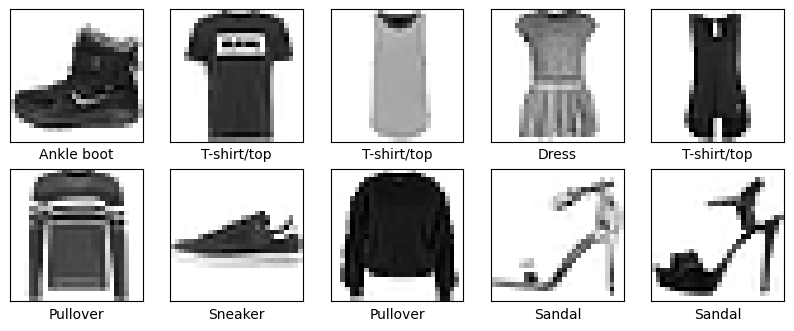

In [12]:
labels_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(labels_names[train_labels[i]])
plt.show()

Let train a convolutional model to solve it.

In [13]:

train_images_conv = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255
test_images_conv = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255

Let train with a basic achictecture .

One convolutional layer with 20 filters , 5 $\times  5$ kernel, relu acivation, 2$\times$2 pooling layers, fully connected layer with 100 neurons, output layer with 10 neurons.

In [14]:
model_cnn_1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=20, kernel_size=5, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(10)
])
model_cnn_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model_cnn_1.fit(train_images_conv, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 32s 16ms/step - loss: 0.4256 - accuracy: 0.8504
Epoch 2/10
1875/1875 [==============================] - 31s 17ms/step - loss: 0.2938 - accuracy: 0.8939
Epoch 3/10
1875/1875 [==============================] - 31s 17ms/step - loss: 0.2519 - accuracy: 0.9079
Epoch 4/10
1875/1875 [==============================] - 31s 17ms/step - loss: 0.2234 - accuracy: 0.9163
Epoch 5/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.1990 - accuracy: 0.9254
Epoch 6/10
1875/1875 [==============================] - 31s 16ms/step - loss: 0.1775 - accuracy: 0.9332
Epoch 7/10
1875/1875 [==============================] - 32s 17ms/step - loss: 0.1595 - accuracy: 0.9402
Epoch 8/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.1427 - accuracy: 0.9476
Epoch 9/10
1875/1875 [==============================] - 31s 17ms/step - loss: 0.1310 - accuracy: 0.9507
Epoch 10/10
1875/1875 [==============================] - 30s 16m

In [17]:
model_cnn_1.evaluate(test_images_conv,  test_labels, verbose=2)

313/313 - 2s - loss: 0.2877 - accuracy: 0.9105 - 2s/epoch - 5ms/step


[0.28774985671043396, 0.9104999899864197]

With this achitecture we can abtained an accuracy of $91.05 $%

Let try another

 32 filters, 2x2 pooling, 64 filters, 2x2 pooling,4 filters, 2x2 pooling, 100 hidden neurons fully connected, 10 neurons for output .

In [18]:
model_cnn_2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
     tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(10,activation='softmax')
])
model_cnn_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model_cnn_2.fit(train_images_conv, train_labels, epochs=10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1875/1875 [==============================] - 56s 29ms/step - loss: 0.5876 - accuracy: 0.7840
Epoch 2/10
1875/1875 [==============================] - 55s 29ms/step - loss: 0.3918 - accuracy: 0.8548
Epoch 3/10
1875/1875 [==============================] - 54s 29ms/step - loss: 0.3349 - accuracy: 0.8759
Epoch 4/10
1875/1875 [==============================] - 53s 28ms/step - loss: 0.2966 - accuracy: 0.8903
Epoch 5/10
1875/1875 [==============================] - 54s 29ms/step - loss: 0.2720 - accuracy: 0.8993
Epoch 6/10
1875/1875 [==============================] - 54s 29ms/step - loss: 0.2500 - accuracy: 0.9066
Epoch 7/10
1875/1875 [==============================] - 53s 28ms/step - loss: 0.2312 - accuracy: 0.9134
Epoch 8/10
1875/1875 [==============================] - 54s 29ms/step - loss: 0.2157 - accuracy: 0.9192
Epoch 9/10
1875/1875 [==============================] - 53s 28ms/step - loss: 0.2018 - accuracy: 0.9236
Epoch 10/10
1875/1875 [==============================] - 54s 29ms/step - lo

In [19]:
model_cnn_2.evaluate(test_images_conv,  test_labels, verbose=2)

313/313 - 3s - loss: 0.3148 - accuracy: 0.8925 - 3s/epoch - 8ms/step


[0.3147861957550049, 0.8924999833106995]

With this achictecture we have more weights but this seems not improve the basics one .

We know that it is hard to find the best achitecture that gives the highest accuracy , it required time to check again and again.


Conclusion: With the basic achitecture i'm able to achieve 91.05% of accuracy.